In [1]:
"""

Source of code: https://dipy.org/documentation/1.0.0./examples_built/snr_in_cc/
Adapted for HCP_EOP dataset by Haley R. Wang (haleywang@ucla.edu), Jan 2022

It takes 2~3 mins to calculate each subject, so it's better to submit a job array to compute in parallel. The author is lazy and prefers letting it run for hours while she watches soccer game. 
But if you have a giant dataset, def use array.

"""

"\n\nSource of code: https://dipy.org/documentation/1.0.0./examples_built/snr_in_cc/\nAdapted for HCP_EOP dataset by Haley R. Wang (haleywang@ucla.edu), Jan 2022\n\nIt takes 2~3 mins to calculate each subject, so it's better to submit a job array to compute in parallel. The author is lazy and prefers letting it run for hours while she watches soccer game. \nBut if you have a giant dataset, def use array.\n\n"

In [2]:
from __future__ import division, print_function

import os
from os.path import expanduser, join

import numpy as np
import nibabel as nib
from dipy.segment.mask import median_otsu
from dipy.reconst.dti import TensorModel
from dipy.io.image import load_nifti


Conducting SNR QC for
/u/project/CCN/kkarlsgo/data/HCP/HCP_EOP/imagingcollection01/control/1010_01_MR/Diffusion_preproc/eddy_multishell/eddy_unwarped_images_dir107.nii.gz
Computing brain mask...
Computing tensors...
Computing worst-case/best-case SNR using the corpus callosum...
Noise standard deviation sigma=  111.860214
SNR for the b=0 image is : 13.64361
SNR for direction 59   [ 0.981852  -0.0361827 -0.186165 ] is : 1.9238598
SNR for direction 51   [0.168179 0.963549 0.20806 ] is : 7.7270837
SNR for direction 66   [-0.0943223  0.0890903  0.991547 ] is : 7.6153235
Conducting SNR QC for
/u/project/CCN/kkarlsgo/data/HCP/HCP_EOP/imagingcollection01/control/1017_01_MR/Diffusion_preproc/eddy_multishell/eddy_unwarped_images_dir107.nii.gz
Computing brain mask...
Computing tensors...
Computing worst-case/best-case SNR using the corpus callosum...
Noise standard deviation sigma=  66.04014
SNR for the b=0 image is : 19.087435
SNR for direction 28   [ 0.987493  0.137659 -0.076859] is : 2.18953


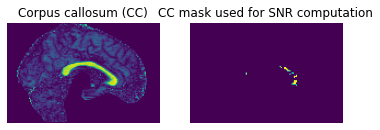

In [3]:
# build the loop for subjects
# assign directory

# change group
group = 'control'
#group = 'AP'
#group = 'NAP'

home = expanduser('/u/project/CCN/kkarlsgo/data/HCP/HCP_EOP/imagingcollection01')
directory = join(home,group)
append_str='_01_MR'
bval_str='_dMRI_dir107_AP.bval'
bvec_str='_dMRI_dir107_AP.bvec'

#change the subj list when needed!!
with open('/u/project/CCN/kkarlsgo/data/HCP/HCP_EOP/imagingcollection01/subj_list/HC_subj.txt', 'r') as SUBJ_List:
    for subj in SUBJ_List:
        
        #setting file name and path etc.
        subj = subj + append_str
        subj = subj.replace("\n", "")
        subj = subj.replace('\t',',')
        
        fbval = subj + bval_str
        fbvec = subj + bvec_str
        
        eddy_folder = os.path.join(directory, subj,'Diffusion_preproc','eddy_multishell')
        fbval = join(eddy_folder,fbval)
        fbvec = join(eddy_folder,fbvec)
            
        subj_data = join(eddy_folder,'eddy_unwarped_images_dir107.nii.gz')
        data, affine, img = load_nifti(subj_data, return_img=True)
        
        # checking if it is a file
        if os.path.isfile(subj_data):
            print('Conducting SNR QC for')
            print(subj_data)
        
        from dipy.io import read_bvals_bvecs
        bvals, bvecs = read_bvals_bvecs(fbval, fbvec)

        from dipy.core.gradients import gradient_table
        gtab = gradient_table(bvals, bvecs)
        
        print('Computing brain mask...')
        b0_mask, mask = median_otsu(data, vol_idx=[0])

        print('Computing tensors...')
        tenmodel = TensorModel(gtab)
        tensorfit = tenmodel.fit(data, mask=mask)
        
        print('Computing worst-case/best-case SNR using the corpus callosum...')
        from dipy.segment.mask import segment_from_cfa
        from dipy.segment.mask import bounding_box

        threshold = (0.6, 1, 0, 0.1, 0, 0.1)
        CC_box = np.zeros_like(data[..., 0])

        mins, maxs = bounding_box(mask)
        mins = np.array(mins)
        maxs = np.array(maxs)
        diff = (maxs - mins) // 4
        bounds_min = mins + diff
        bounds_max = maxs - diff

        CC_box[bounds_min[0]:bounds_max[0],
               bounds_min[1]:bounds_max[1],
               bounds_min[2]:bounds_max[2]] = 1

        mask_cc_part, cfa = segment_from_cfa(tensorfit, CC_box, threshold,
                                             return_cfa=True)

        cfa_img = nib.Nifti1Image((cfa*255).astype(np.uint8), affine)
        mask_cc_part_img = nib.Nifti1Image(mask_cc_part.astype(np.uint8), affine)
        nib.save(mask_cc_part_img, 'mask_CC_part.nii.gz')
        
        import matplotlib.pyplot as plt
        region = 72
        fig = plt.figure('Corpus callosum segmentation')
        plt.subplot(1, 2, 1)
        plt.title("Corpus callosum (CC)")
        plt.axis('off')
        red = cfa[..., 0]
        plt.imshow(np.rot90(red[region, ...]))

        plt.subplot(1, 2, 2)
        plt.title("CC mask used for SNR computation")
        plt.axis('off')
        plt.imshow(np.rot90(mask_cc_part[region, ...]))
        fig.savefig("CC_segmentation.png", bbox_inches='tight')
        
        mean_signal = np.mean(data[mask_cc_part], axis=0)
        
        from scipy.ndimage.morphology import binary_dilation
        mask_noise = binary_dilation(mask, iterations=10)
        mask_noise[..., :mask_noise.shape[-1]//2] = 1
        mask_noise = ~mask_noise
        mask_noise_img = nib.Nifti1Image(mask_noise.astype(np.uint8), affine)
        nib.save(mask_noise_img, 'mask_noise.nii.gz')

        noise_std = np.std(data[mask_noise, :])
        print('Noise standard deviation sigma= ', noise_std)
        
        # Exclude null bvecs from the search
        idx = np.sum(gtab.bvecs, axis=-1) == 0
        gtab.bvecs[idx] = np.inf
        axis_X = np.argmin(np.sum((gtab.bvecs-np.array([1, 0, 0]))**2, axis=-1))
        axis_Y = np.argmin(np.sum((gtab.bvecs-np.array([0, 1, 0]))**2, axis=-1))
        axis_Z = np.argmin(np.sum((gtab.bvecs-np.array([0, 0, 1]))**2, axis=-1))

        for direction in [0, axis_X, axis_Y, axis_Z]:
            SNR = mean_signal[direction]/noise_std
            if direction == 0:
                print("SNR for the b=0 image is :", SNR)
            else:
                print("SNR for direction", direction, " ",
                      gtab.bvecs[direction], "is :", SNR)